# Elastic and viscoelastic modeling

In this notebook, we will explore the theorical background of the two main way of modelling in SeisCL as well as their implications in the performance of the program.

## Theory

Full waveform inversion requires the solution of the heregenous wave equation. We adopt the velocity-stress formulation in which the viscoelastic effects are modeled by L generalized standard linear solid (GSLS) [Liu, et al., 1976](https://doi.org/10.1111/j.1365-246X.1976.tb01261.x). The wave equation is then given by :

<br>

$$ \partial_t v_i - \frac{1}{\rho} \partial_j \sigma_{ij} = f_{vi} $$

where

$$ v(\mathbf{x}, t) : \textrm{Particle velocity} \hspace{3cm}  \sigma(\mathbf{x},t) : \textrm{Stress} \hspace{3cm} f(\mathbf{x},t) : \textrm{Source term}  \hspace{3cm} \rho(\mathbf{x}) : \textrm{Density} $$


<br>

This equation is satisfied for any volume, independently if it is filled with a liquid, a gas or rock but it does not describe how the medium deforms under external stress. For an elastic medium generalized Hooke's law give us a linear relationship between stress and strain :

<br>


$$ \sigma_{ij} = \lambda \theta \delta_{ij} + 2 \mu \epsilon_{ij} $$

where

$$ \lambda \textrm{ and } \mu \textrm{ : Lamé parameter}   \hspace{3cm} \epsilon_{ij} = \left( \partial_j u_i + \partial_i u_j \right)    \textrm{ : strain tensor}     \hspace{3cm}    \theta = \epsilon_{11} + \epsilon_{22} + \epsilon_{33} \textrm{ : cubic dilatation}  $$

<br>

For a viscoelastic medium, we adopt the GSLS model, which gives the following stress-strain relationship:

<br>


$$  \partial_t \sigma_{ij} - \left[ M \frac{1 + \tau_p}{1 + \alpha \tau_p} - 2\mu \frac{1 + \tau_s}{1 + \alpha \tau_s} \right] \partial_k v_k \delta_{ij} - \mu \frac{1 + \tau_s}{1 + \alpha \tau_s} \left( \partial_j v_i + \partial_i v_j \right) - r_{ijl} \delta_l = f_{\sigma i j} $$


where $ r_{ijl} $ are the memory variables, given by : 

<br>

$$  \partial_t r_{ijl} - \frac{1}{\tau_{\sigma l}} \left[ \left( M \frac{\tau_p}{1 + \alpha \tau_p} - 2\mu \frac{\tau_s}{1 + \alpha \tau_s} \right) \partial_k v_k \delta_{ij}   + \mu \frac{\tau_s}{1 + \alpha \tau_s} \left( \partial_j v_i + \partial_i v_j \right) + r_{ijl} \right] = 0$$


with :

$$ M(\mathbf{x}) \textrm{ : P-wave modulus} \hspace{3cm} \mu(\mathbf{x}) : \textrm{Shear modulus}   \hspace{3cm} \tau_p(\mathbf{x}) : \textrm{ P-wave attenuation} \hspace{3cm} \tau_s(\mathbf{x}) : \textrm{S-wave attenuation} \hspace{3cm} \tau_{\sigma l} : \textrm{Stress relaxation time of the } l^{th} \textrm{ Maxwell body}$$




## Finite difference modeling

It is obvious, less time ...


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
from copy import deepcopy

In [31]:
seisElas = SeisCL()

seisElas.workdir = '/home/ocaron/scratch'

seisElas.csts['nmax_dev'] = 4
seisElas.csts['no_use_GPUs'] = np.array([0])

seisElas.csts['ND'] = 3
seisElas.csts['N'] = np.array([300, 300, 300])
seisElas.csts['dt'] = dt = 0.2e-03
seisElas.csts['dh'] = dh = 2
seisElas.csts['NT'] = NT = 2000


seisElas.csts['seisout'] = 1


# seisElas.csts['abs_type'] = 1
# seisElas.csts['nab'] = 45  # Width in grid points of the absorbing layer
# seisElas.csts['abpc'] = 6  # Exponential decay of the absorbing layer

In [32]:
N = seisElas.csts['N'][0]

sx = N // 2 * dh
sy = N // 2 * dh
sz = N // 2 * dh

seisElas.src_pos_all = np.stack([[sx], [sy], [sz], [0], [100]], axis=0)

gx = np.arange(50*dh, 250*dh, dh)
gy = gx * 0 + 20 * dh # + N // 2 * dh
gz = gy         #+ N // 2 * dh
srcid = gx*0
recid = np.arange(0, len(gx))

seisElas.rec_pos_all = np.stack([gx, gy, gz, srcid, recid, gx*0, gx*0, gx*0], axis=0)

In [33]:
seisVisco = deepcopy(seisElas)

seisVisco.csts['FL'] = np.array([seisVisco.csts['f0']])
seisVisco.csts['L'] = 1

In [34]:
vp = 3500
vs = 2000
rho = 2000
taup = 0
taus = 0

vp_a = np.zeros(seisElas.csts['N']) + vp
vs_a = np.zeros(seisElas.csts['N']) + vs
rho_a = np.zeros(seisElas.csts['N']) + rho
taup_a = np.zeros(seisElas.csts['N']) + taup
taus_a = np.zeros(seisElas.csts['N']) + taus

model_Elas = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}

model_Visco = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a + 0.2, "taus": taus_a + 0.2}


In [35]:
gsid = seisElas.rec_pos_all[3,:]

seisElas.set_forward(gsid, model_Elas, withgrad=False)
InfoElas = seisElas.execute()
data_Elas = seisElas.read_data()

seisVisco.set_forward(gsid, model_Visco, withgrad=False)
InfoVisco = seisVisco.execute()
data_Visco = seisVisco.read_data()

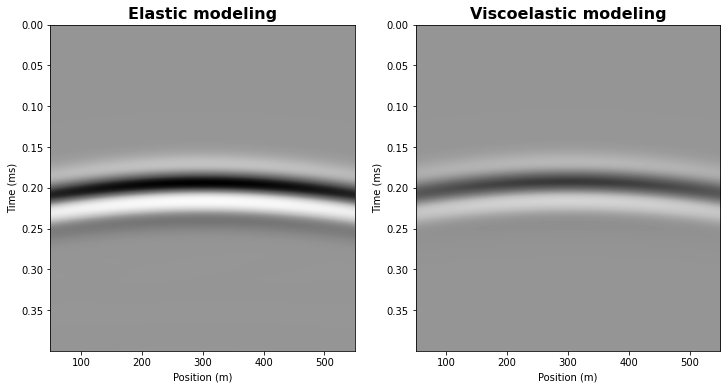

In [36]:
_, ax = plt.subplots(1, 2, figsize=[12, 6])
extent = [25*dh, 275*dh, (data_Elas.shape[0]-1)*dt, 0]
clip = 1
vmax = np.max(data_Elas) * clip
vmin = -vmax
ax[0].imshow(data_Elas, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[0].set_title("Elastic modeling", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Position (m)")
ax[0].set_ylabel("Time (ms)")

ax[1].imshow(data_Visco, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[1].set_title("Viscoelastic modeling", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Position (m)")
ax[1].set_ylabel("Time (ms)")


plt.show()

## Time difference

Blablabla less

In [37]:
# dataDim_E = []
# retourDim_E = []

# dataDim_V = []
# retourDim_V = []

# seisElas = SeisCL()
# seisElas.csts['no_use_GPUs'] = np.array([0])
# seisElas.workdir = '/home/ocaron/scratch'
# seisElas.csts['nmax_dev'] = 4

# seisElas.csts['ND'] = 3
# seisElas.csts['dt'] = dt = 0.2e-03
# seisElas.csts['dh'] = dh = 2
# seisElas.csts['NT'] = NT = 2000

# seisElas.csts['seisout'] = 1

# seisElas.fill_src_rec_reg()

# seisVisco = deepcopy(seisElas)

# seisVisco.csts['FL'] = np.array([seisVisco.csts['f0']])
# seisVisco.csts['L'] = 1

# gsid = seisElas.rec_pos_all[3,:]

# for N in range(50,401,50):
    
#     seisElas.csts['N'] = np.array([N, N, N])
#     seisVisco.csts['N'] = np.array([N, N, N])

#     vp_a = np.zeros(seisElas.csts['N']) + vp
#     vs_a = np.zeros(seisElas.csts['N']) + vs
#     rho_a = np.zeros(seisElas.csts['N']) + rho
#     taup_a = np.zeros(seisElas.csts['N']) + taup
#     taus_a = np.zeros(seisElas.csts['N']) + taus

#     model_Elas = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}

#     model_Visco = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a + 0.2, "taus": taus_a + 0.2}


#     seisElas.set_forward(gsid, model_Elas, withgrad=False)
#     InfoElas = seisElas.execute()
#     datafd_Elas = seisElas.read_data()

#     dataDim_E.append(datafd_Elas)
#     retourDim_E.append(InfoElas)

#     seisVisco.set_forward(gsid, model_Visco, withgrad=False)
#     InfoVisco = seisVisco.execute()
#     datafd_Visco = seisVisco.read_data()

#     dataDim_V.append(datafd_Visco)
#     retourDim_V.append(InfoVisco)



In [38]:
# tempsE = []
# tempsV = []

# for i in range(len(retourDim_E)):
#     retourstr_E = retourDim_E[i].split()
#     retourstr_V = retourDim_V[i].split()
#     try:
#         idx_real_E = retourstr_E.index('real')
#         idx_real_V = retourstr_V.index('real')
#         tempsE.append(float(retourstr_E[idx_real_E + 6]))
#         tempsV.append(float(retourstr_V[idx_real_V + 6]))
#     except:
#         pass


In [39]:
# print(np.array(tempsV)/np.array(tempsE))

In [40]:
# for i in range(len(retourDim_E)):
#     print(retourDim_E[i])
#     print(retourDim_V[i])

In [41]:
# AllData = [dataDim_E, retourDim_E, dataDim_V, retourDim_V]

# np.save('DataTimeTest2', AllData)
